# МТС Geohack.112

In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import collections 
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, cross_val_predict
import lightgbm as lgb
from scipy.stats import kendalltau
import warnings

In [2]:
df_zones = pd.read_csv('./data/zones.csv', index_col='zone_id')
df_zones.head()
tagged_nodes = pd.read_pickle('./osm/tagged_nodes.pickle')

# Дополнительная дата

В данном разделе представлена дополнительная дата, которую я взял из открытых источников.

## Статистика по пожарам

Статистику по пожарам брал с сайта [МЧС России](https://moscow.mchs.ru/document/1316565) по Москве. Приведенные далее данные можно найти в "Анализ обстановки с пожарами и их последствиями за 2017 год" (страницаы 34-35) Я перевел данные в доступный вид при помощи [pdftables](https://pdftables.com/). 

Колонки представляют собой статистику по количеству пожаров в 2017 и 2016 году ($fiers2017$, $fiers2016$), количество смертей от пожаров ($deaths$), травм ($injuries$), спасённых человек ($saved$), материальный ущерб ($damage$), количество загораний ($zagoraniya$), удельные значения на 100 тыс человек, население ($population$). $lat_c$, $lon_c$ - широта и долгота середины района (субъективная оценка). 

В папке есть еще файл "fiers_AO" - статистики по административным округам. Сумма по районам АО отличается от со статистики АО.

In [3]:
fiers = pd.read_csv('./additional_data/fiers_area.csv')
print('Shape:', fiers.shape)
fiers.head()

Shape: (146, 26)


,AO,area,lat_c,lon_c,fiers2017,fiers2016,deaths2017,deaths2016,injuries2017,injuries2016,...,zagoraniya2017,zagoraniya2016,fiers2017_100k,fiers2016_100k,deaths2017_100k,deaths2016_100k,injuries2017_100k,injuries2016_100k,population2017,population2016
0,Центральный АО,Арбат,55.751066,37.574420,36.0,35.0,1.0,NaN,3.0,NaN,...,3.0,2.0,104.66,102.90,8.72,NaN,197.29,5.86,34396.0,34012.0
1,Центральный АО,Басманный,55.766543,37.635249,80.0,83.0,2.0,1.0,7.0,9.0,...,36.0,28.0,72.67,75.43,6.36,8.18,0.57,7.68,110083.0,110042.0
2,Центральный АО,Замоскворечье,55.734974,37.616885,35.0,74.0,NaN,NaN,1.0,1.0,...,NaN,1.0,60.48,128.20,1.73,1.73,112.34,175.31,57871.0,57722.0
3,Центральный АО,Красносельский,55.776518,37.640349,36.0,34.0,NaN,NaN,3.0,3.0,...,14.0,11.0,74.27,70.36,6.19,6.21,NaN,10.66,48474.0,48324.0
4,Центральный АО,Мещанский,55.778231,37.611418,23.0,40.0,NaN,NaN,1.0,5.0,...,15.0,14.0,38.26,66.65,1.66,8.33,0.31,3.43,60121.0,60014.0


## Статистика ДТП

Вся статистика по ДТП в Москве взята с сайта [Госавтоинспекции](http://stat.gibdd.ru/) (вкладка "Выгрузка показателей БДД" -> "Карточки ДТП" -> "Дорожно-транспортные происшествия"). $lat_c$, $lon_c$ - широта и долгота середины района (субъективная оценка). 

In [4]:
accidents = pd.read_csv('./additional_data/accidents.csv')
print('Shape:', accidents.shape)
accidents.head()

Shape: (125, 7)


,area,lat_c,lon_c,Погибло,Ранено,Кол-во ТС,Кол-во участников
0,Алексеевский,55.811254,37.617419,0.0,15.0,25.0,35.0
1,Алтуфьевский,55.879000,37.569239,0.0,10.0,15.0,20.0
2,Арбат,55.751066,37.574420,10.0,20.0,35.0,60.0
3,Аэропорт,55.800686,37.524482,0.0,30.0,35.0,60.0
4,Бабушкинский,55.866964,37.644678,5.0,35.0,75.0,95.0


## Статистика по преступлениям 

Статистика взята с [сайта прокуратуры Москвы](http://www.mosproc.ru/statistics/). Период - за январь-декабрь 2017. $lat_c$, $lon_c$ - широта и долгота середины административного округа (субъективная оценка). $crimes$ - количества преступления, совершенные женщинами и мужчинами соответственно. 

In [5]:
crimes = pd.read_csv('./additional_data/crimes.csv')
print('Shape:', crimes.shape)
crimes.head()

Shape: (11, 5)


,AO,lat_c,lon_c,crimes_woman,crimes_man
0,Центральный АО,55.7568,37.6191,868.0,4050.0
1,Северо-Восточный АО,55.8574,37.6230,623.0,3293.0
2,Восточный АО,55.7922,37.7871,970.0,4571.0
3,Юго-Восточный АО,55.6929,37.7693,597.0,3411.0
4,Южный АО,55.6383,37.6553,813.0,3595.0


In [6]:
# введем дополнительные фичи - общее количество преступлений и удельные показатели преступности 
population_AO_2017 = fiers[['AO','population2017']].groupby('AO').agg('sum').reset_index()
crimes = pd.merge(crimes, population_AO_2017, how='left', on='AO')
crimes['crimes_tot'] = crimes['crimes_man'] + crimes['crimes_woman']
crimes['crimes_woman_spec'] = crimes['crimes_woman'] / crimes['population2017']
crimes['crimes_man_spec'] = crimes['crimes_man'] / crimes['population2017']
crimes['crimes_tot_spec'] = crimes['crimes_tot'] / crimes['population2017']

In [7]:
crimes.head()

,AO,lat_c,lon_c,crimes_woman,crimes_man,population2017,crimes_tot,crimes_woman_spec,crimes_man_spec,crimes_tot_spec
0,Центральный АО,55.7568,37.6191,868.0,4050.0,769630.0,4918.0,0.001128,0.005262,0.006390
1,Северо-Восточный АО,55.8574,37.6230,623.0,3293.0,1415283.0,3916.0,0.000440,0.002327,0.002767
2,Восточный АО,55.7922,37.7871,970.0,4571.0,1507198.0,5541.0,0.000644,0.003033,0.003676
3,Юго-Восточный АО,55.6929,37.7693,597.0,3411.0,1385385.0,4008.0,0.000431,0.002462,0.002893
4,Южный АО,55.6383,37.6553,813.0,3595.0,1624339.0,4408.0,0.000501,0.002213,0.002714


# Разбираемся с OpenStreetMap 

In [8]:
# лист всех тагов 
osm_tags = []
for i in range(len(tagged_nodes)):
    if (len(tagged_nodes[i].tags)>0):
        for j in tagged_nodes[i].tags:
            osm_tags.append(j)
tags, count = np.unique(osm_tags,return_counts=True)

tags_count = pd.DataFrame({'tag':tags, 
                           'count':count}).sort_values(by='count',ascending=False).reset_index(drop=True)

В датасете есть около 1,6к различных тэгов, причем в них очень много мусора - тэгов которые встречаются реже 10 раз. Можно попробовать работать только с теми, которые встречаются чаще некого $threshold$, наделать статистик и фич и скормить бустам - деревья сами разберутся (warring: без feature selection - это путь в никуда). 

Мы пойдем по другому пути. Вручную я отобрал несколько тэгов которые могут оказывать влияние на целевую переменную. 

Unique tags: 1588


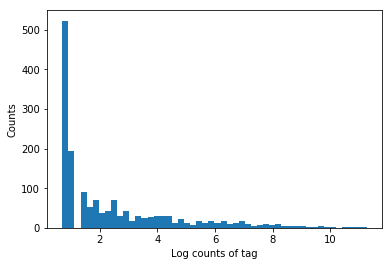

In [9]:
print('Unique tags:', tags_count.shape[0])
plt.hist(np.log1p(tags_count['count']), bins=50)
plt.xlabel('Log counts of tag')
plt.ylabel('Counts')
plt.show()

In [10]:
tags_count.head()

,count,tag
0,78314,name
1,56678,amenity
2,49919,highway
3,39660,entrance
4,36952,barrier


In [11]:
# отобранные тэги 
tags_list = [
    'train', 'religion', 'bank', 
    'danger', 'cafe', 'subway', 'clinic', 
    'education', 'healthcare'
            ]  

Забавно, что кто-то отметил кошку на карте. 

In [12]:
tags_count[tags_count.tag=='cat']

,count,tag
1147,1,cat


## Построение таблицы признаков

Воспользуемся [готовым скриптом](https://github.com/datasouls/mts-geohack/blob/master/Geohack112_StarterKit.ipynb) по генерации фич от организаторов. Дополним фичи новыми данными. 

In [13]:
df_features = collections.OrderedDict([])

### Расстояние до Кремля

In [14]:
import math

kremlin_lat, kremlin_lon = 55.753722, 37.620657

def dist_calc(lat1, lon1, lat2, lon2):
    R = 6373.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

df_features['distance_to_kremlin'] = df_zones.apply(
    lambda row: dist_calc(row.lat_c, row.lon_c, kremlin_lat, kremlin_lon), axis=1)

### Статистика по точкам из OSM

In [15]:
# базовые фичи
POINT_FEATURE_FILTERS = [
    ('tagged', lambda node: len(node.tags) > 0),
    ('railway', lambda node: node.tags.get('railway') == 'station'),
    ('shop', lambda node: 'shop' in node.tags),
    ('public_transport', lambda node: 'public_transport' in node.tags),
]

# доп фичи
for i in tags_list:
    POINT_FEATURE_FILTERS.append((i, lambda node: i in node.tags))

# центры квадратов в виде матрицы
X_zone_centers = df_zones[['lat_c', 'lon_c']].as_matrix()

for prefix, point_filter in POINT_FEATURE_FILTERS:
    
    print(prefix)
    
    # берем подмножество точек в соответствии с фильтром
    coords = np.array([
        [node.lat, node.lon]
        for node in tagged_nodes
        if point_filter(node)
    ])

    # строим структуру данных для быстрого поиска точек
    neighbors = NearestNeighbors().fit(coords)
    
    # признак вида "количество точек в радиусе R от центра квадрата"
    for radius in [0.001, 0.003, 0.005, 0.007, 0.01]:
        dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
        df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])

    # признак вида "расстояние до ближайших K точек"
    for n_neighbors in [3, 5, 10, 15, 21]:
        dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
        df_features['{}_mean_dist_k_{}'.format(prefix, n_neighbors)] = dists.mean(axis=1)
        df_features['{}_max_dist_k_{}'.format(prefix, n_neighbors)] = dists.max(axis=1)
        df_features['{}_std_dist_k_{}'.format(prefix, n_neighbors)] = dists.std(axis=1)

    # признак вида "расстояние до ближайшей точки"
    df_features['{}_min'.format(prefix)] = dists.min(axis=1)

tagged
railway
shop
public_transport
train
religion
bank
danger
cafe
subway
clinic
education
healthcare


In [16]:
df_features = pd.DataFrame(df_features, index=df_zones.index).reset_index()
df_features.head()

,zone_id,distance_to_kremlin,tagged_points_in_0.001,tagged_points_in_0.003,tagged_points_in_0.005,tagged_points_in_0.007,tagged_points_in_0.01,tagged_mean_dist_k_3,tagged_max_dist_k_3,tagged_std_dist_k_3,...,healthcare_mean_dist_k_10,healthcare_max_dist_k_10,healthcare_std_dist_k_10,healthcare_mean_dist_k_15,healthcare_max_dist_k_15,healthcare_std_dist_k_15,healthcare_mean_dist_k_21,healthcare_max_dist_k_21,healthcare_std_dist_k_21,healthcare_min
0,0,56.852292,0,1,2,2,2,0.006777,0.015403,0.006120,...,0.220350,0.273384,0.041592,0.238714,0.277386,0.042758,0.275959,0.399982,0.072478,0.141260
1,1,56.511876,0,0,0,0,2,0.008668,0.010560,0.001347,...,0.217375,0.268797,0.040150,0.235177,0.272606,0.041341,0.272318,0.394435,0.071789,0.148631
2,2,56.173822,0,0,0,0,0,0.013769,0.015696,0.002323,...,0.214564,0.264367,0.039119,0.231802,0.267973,0.040187,0.268821,0.388979,0.071238,0.156053
3,3,55.838172,0,0,0,0,0,0.020577,0.023549,0.003754,...,0.211924,0.260101,0.038536,0.228594,0.263495,0.039321,0.265335,0.385454,0.070592,0.163519
4,4,55.504970,0,0,0,0,0,0.026699,0.030437,0.003545,...,0.209461,0.256008,0.038421,0.225560,0.259181,0.038767,0.261751,0.380664,0.069630,0.158611


Некоторые значения статистики содержат пропущенные значения. Заменим их на нули. 

In [17]:
fiers = fiers.fillna(0)
crimes = crimes.fillna(0)
accidents = accidents.fillna(0)

При добавлении статистики по происшествиям можно использовать значения ближайшего района (n_neighbors=1) или получить взвешенную статистику пропорционально расстоянию между центром квадрата и центром района или АО (n_neighbors=var). В любом случае этот гиперпараметр можно и нужно тюнить.  

In [18]:
df_features = pd.merge(df_features, df_zones.reset_index()[['zone_id','lat_c','lon_c']], how='left', on='zone_id')

# добавляем статистику по пожарам
for i in list(fiers.columns[4:]):
    print(i)
    knn = KNeighborsRegressor(n_neighbors=15, weights='distance')
    knn.fit(fiers[['lat_c', 'lon_c']], fiers[i])
    y_hat = knn.predict(df_features[['lat_c', 'lon_c']])
    df_features['fiers_'+str(i)] = y_hat

# добавляем статистику по преступлениям 
for i in ['crimes_woman','crimes_man','crimes_tot','crimes_woman_spec','crimes_man_spec','crimes_tot_spec']:
    print(i)
    knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn.fit(crimes[['lat_c', 'lon_c']], crimes[i])
    y_hat = knn.predict(df_features[['lat_c', 'lon_c']])
    df_features['crimes_'+str(i)] = y_hat
    
# добавляем статистику по дтп 
for i in ['Погибло','Ранено','Кол-во ТС','Кол-во участников']:
    print(i)
    knn = KNeighborsRegressor(n_neighbors=15, weights='distance')
    knn.fit(accidents[['lat_c', 'lon_c']], accidents[i])
    y_hat = knn.predict(df_features[['lat_c', 'lon_c']])
    df_features['accidents_'+str(i)] = y_hat

fiers2017
fiers2016
deaths2017
deaths2016
injuries2017
injuries2016
saved2017
saved2016
evacuated2017
evacuated2016
damage2017
damage2016
zagoraniya2017
zagoraniya2016
fiers2017_100k
fiers2016_100k
deaths2017_100k
deaths2016_100k
injuries2017_100k
injuries2016_100k
population2017
population2016
crimes_woman
crimes_man
crimes_tot
crimes_woman_spec
crimes_man_spec
crimes_tot_spec
Погибло
Ранено
Кол-во ТС
Кол-во участников


In [19]:
df_features = df_features.set_index('zone_id')
df_features = df_features.drop(['lat_c','lon_c'],axis=1)
print('Shape:', df_features.shape)

Shape: (22172, 306)


# Тренируем модель 

В качестве валидации будем использовать GroupKFold. Идея такого полхода валидации состоит в том, что одна группа (в нашем случае - один район) будет принадлежать только одному фолду. Такое разбите максимально близко к разбиению в данной задаче - на западную и восточную части города. 

In [20]:
gkf = GroupKFold(4)
df_zones_train = df_zones.query('is_test == 0 & is_target == 1')

le = LabelEncoder()
fiers['area_labels'] = le.fit_transform(fiers['area'])

# определяем к какому району относится квадрат по минимальному расстоянию между центрами квадрата и района 
knn_clas = KNeighborsClassifier(n_neighbors=1)
knn_clas.fit(fiers[['lat_c','lon_c']], fiers['area_labels'])
area_id = knn_clas.predict(df_zones_train[['lat_c','lon_c']])

Логика обучения модели такова: по валидации выбираем оптимальное количество деревьев, затем делаем крос-вал предикт для оценки метрики. Поскольку данных не много, мы можем позволить себе такую вольность. 

Обучаем отдельную модель для каждого дня. 

In [21]:
%%time
warnings.filterwarnings("ignore")

params = {
    'objective':'tweedie',
    'learning_rate': 0.005, 
    'random_state': 163000,
    'subsample': 0.75,
    'reg_lambda': 1,
    }

scores = []
opt_rounds = []
for day in range(7):
    # подбираем оптимальное количество деревьев для обучения 
    X_train = df_features.loc[df_zones_train.index, :]
    y_train = np.log1p(df_zones.loc[df_zones_train.index, 'calls_wd'+str(day)])
    train_data = lgb.Dataset(X_train, label=y_train)
    hist = lgb.cv(params, train_data, verbose_eval=None,
                  early_stopping_rounds=150, num_boost_round=424242, 
                  #nfold=5, stratified=False
                  folds = gkf.split(df_zones_train,df_zones_train,area_id)
                 ) 
    
    opt_round = np.argmin(hist['tweedie-mean'])
    opt_rounds.append(opt_round)
    params['n_estimators'] = opt_round
    gbm = lgb.LGBMRegressor(**params)
    
    # вычисляем значение метрики 
    y_cros_val = cross_val_predict(gbm, X_train, y_train, 
                                   #cv = 5, 
                                   cv=gkf.split(df_zones_train,df_zones_train,area_id),
                                   n_jobs=-1
                                  )
    y_cros_val = np.exp(y_cros_val) - 1
    score = kendalltau(y_train, y_cros_val).correlation
    scores.append(score)
    print('Day:', str(day), 'Score: ', score)
    
print('Total score:', np.mean(scores))

Day: 0 Score:  0.6586879357924876
Day: 1 Score:  0.6614241010042836
Day: 2 Score:  0.6624649568106205
Day: 3 Score:  0.6652046874248476
Day: 4 Score:  0.6661385223225323
Day: 5 Score:  0.6524451661833042
Day: 6 Score:  0.644505780863573
Total score: 0.6586958786288071
Wall time: 5min 17s


## Делаем прогноз 

In [22]:
idx_test = df_zones.query('is_test == 1').index

In [23]:
%%time
predictions = []
for day in range(7):
    print('Day:', str(day))
    
    # учим 
    X_train = df_features.loc[df_zones_train.index, :]
    y_train = np.log1p(df_zones.loc[df_zones_train.index, 'calls_wd'+str(day)])
    train_data = lgb.Dataset(X_train, label=y_train)
    X_test  = df_features.loc[idx_test, :]
    
    # предсказываем 
    gbm = lgb.train(params, train_data, num_boost_round=opt_rounds[day])
    
    # записываем 
    y_hat = gbm.predict(X_test)
    y_hat = np.exp(y_hat) - 1
    predictions.append(y_hat)

Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Wall time: 44.8 s


In [24]:
target_columns = ['calls_wd{}'.format(d) for d in range(7)]
df_test_predictions = pd.DataFrame(np.transpose(np.array(predictions)))
df_test_predictions.columns = target_columns
df_test_predictions['zone_id'] = idx_test
df_test_predictions = df_test_predictions[['zone_id']+target_columns]

df_test_predictions.to_csv('./submissions/sub1.csv')
df_test_predictions.head()

# score validation: 0.6586958786288071
# score lb: 0.6505596991693914

,zone_id,calls_wd0,calls_wd1,calls_wd2,calls_wd3,calls_wd4,calls_wd5,calls_wd6
0,79,0.040713,0.041571,0.020598,0.041223,0.038875,0.034039,0.054431
1,80,0.029717,0.022987,0.017550,0.034124,0.027219,0.026874,0.039640
2,81,0.029717,0.022987,0.017152,0.024386,0.027219,0.028093,0.039640
3,82,0.029786,0.022987,0.017185,0.023237,0.027518,0.026656,0.038370
4,83,0.030158,0.024303,0.017276,0.021832,0.026090,0.026723,0.039135


Напоследок посмотрим на важность фич. Видно, что фичи полученные из новых дата сетов находятся в топе по важности. 

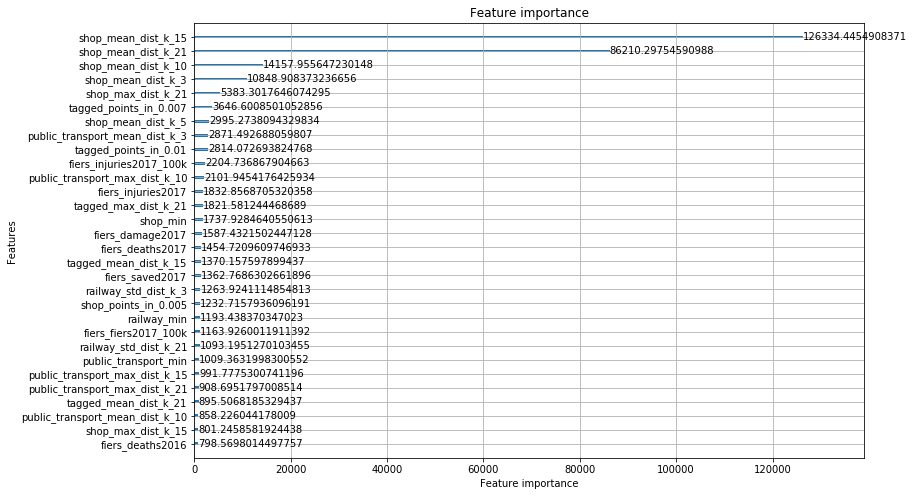

In [25]:
lgb.plot_importance(gbm, figsize=(12,8), importance_type='gain', max_num_features=30)

## Что можно улучшить 

- Добавить статистики по ближайшим районам как фичи. То есть использовать не усредненные статистики (knn), а статистики ближайшего района, второго по близости итп. 
- Кластеризовать районы по некому признаку и использовать как категориальную фичу. 
- Попробовать различные трансформации целевой переменной: оставить как есть, логарифмирование, степенные преобразования, [Бокса-Кокса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%91%D0%BE%D0%BA%D1%81%D0%B0-%D0%9A%D0%BE%D0%BA%D1%81%D0%B0) 
- Попробовать различные objective function в lighgbm (tweedie, poisson). 
- [Feature selection](https://github.com/scikit-learn-contrib/boruta_py) & [hyper-parameters optimization](https://github.com/hyperopt/hyperopt)
